In [1]:
%load_ext autoreload
%autoreload 2

## Calculate initialisation locations along the shelf on a specific isobath

In [45]:
informalname = 'Shelf' # name for positions
bathyT = 1000 # depth of isobath
separation = 500 # desired separation (in km)
maxdistance = None # how far along the contour you wish to go
x,y = 0,-70 # reference point to start at to find contour

### Load data

In [46]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
import bsose.preprocess as pp
from utils import geo

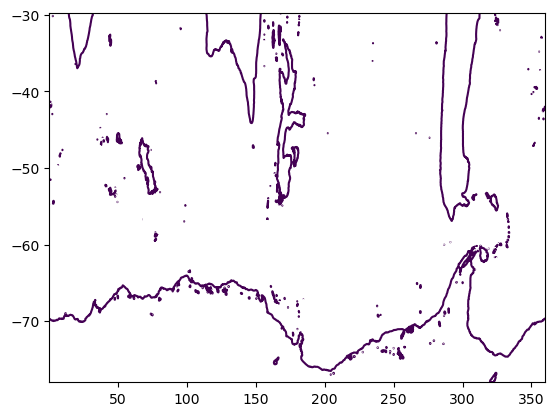

In [47]:
# Load MLD file to get Depth variable
variables = ['MLD']
paths = pp.getpaths_bsose(variables=variables)
ds = xr.open_mfdataset(paths)
cs = plt.contour(ds['XC'],ds['YC'],ds['Depth'],levels=[bathyT]);

### Find locations along contour

In [48]:
# 1. Find the contour nearest to a secific reference point
_,segment_index,index,xmin,ymin,_ = cs.find_nearest_contour(x,y,pixel=False)
# Get the vertices for that contour
c = cs.allsegs[0][segment_index]

# 2. Calculate distances between points on the contour
# differences in lat-lon
dl = np.diff(c,axis=0)
# lat-lon of mid-points
lm = 0.5*(c[1:,:]+c[:-1,:])
# convert distances to metres
dx, dy = geo._degrees_to_meters(dl[:,0],dl[:,1],lm[:,0],lm[:,1])
# determine distances along the contour
distance = np.sqrt(dx**2+dy**2)*1e-3
cumdistance = np.cumsum(distance)

# 3. Get the lat and lon of evenly spaced points along the contour
# adjust cumulative distance to startpoint
cumdistanceadj = cumdistance-cumdistance[index]
# find the points at which the cumulative distance is divisible by the separation
minima, = argrelextrema((cumdistance[index:]%separation),np.less_equal,order=4)
# construct a list of all indices
minima = np.append(index,minima)+index
if maxdistance is not None:
    # find the closest point to the max distance
    maxind = np.argmin(np.abs(cumdistanceadj-maxdistance))
    minima = minima[minima<maxind]
# Get the lat and lon of points along contour
init = c[minima,:]

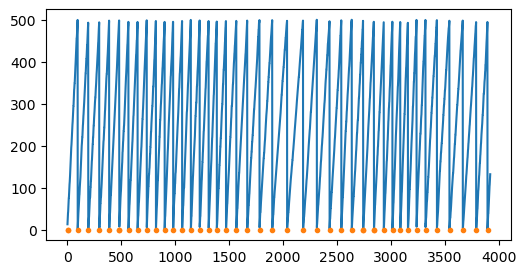

In [49]:
# Check that you picked up all the minima (an orange dot at each)
# adjust 'order' to capture all
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(cumdistance[index:]%separation)
ax.plot(minima,np.zeros(len(minima)),marker='.',linestyle=' ',color='tab:orange')

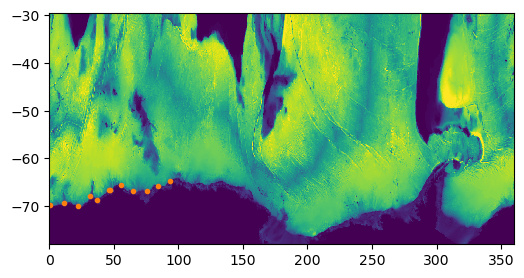

In [50]:
fig,ax = plt.subplots(figsize=(6,3))
ax.pcolormesh(ds['XC'],ds['YC'],ds['Depth'], shading='auto')
ax.plot(initlon,initlat,marker='.',linestyle=' ',color='tab:orange')

### Save locations

In [51]:
savelist = [informalname,
            'level-'+str(bathyT),
            'sep-'+str(separation)]
if maxdistance is not None:
    additions = ['startpoint-x'+str(x)+'y'+str(y),
                 'maxd-'+str(maxdistance)]
    for a in additions:
        savelist.append(a)
savelist.append('txt')
savename = '.'.join(savelist)
np.savetxt('../../data/'+savename,init)

In [53]:
savename

'Shelf.level-1000.sep-500.txt'